# X‑ray Fracture Detection — Colab Template
*Auto-generated on 2025-09-01. Plug in your dataset path in Drive and run top-to-bottom.*

This notebook is structured to support **incremental experiments**:
1) Configuration  2) Environment setup  3) Data loading  4) Training  5) Evaluation  6) LIME explanations  7) Save artifacts.

> Tip: Keep data in Google Drive, code in GitHub. Use a Colab badge in your README.

## 0. Configuration

In [20]:

# === User-configurable settings ===
PROJECT_NAME = "xray-fracture-experiments"
#DATA_DIR = "/content/drive/MyDrive/fracatlas/data"  # change this to your dataset path
DATA_DIR = "/content/drive/MyDrive/Computer Vision Project work/Data"
EXP_DIR = "/content/drive/MyDrive/fracatlas/experiments"  # where to save runs/models
MODEL_NAME = "resnet50"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 5            # increase when ready
LR = 1e-4
SEED = 42

# Optional: If you host code in GitHub, set these and uncomment clone step below
GITHUB_USER = ""     # e.g., "your-username"
GITHUB_REPO = ""     # e.g., "fracture-detection"
GITHUB_BRANCH = "main"

print("Config loaded.")


Config loaded.


## 1. Environment & Drive

In [2]:
# If on Colab, install/upgrade deps
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install torch torchvision lime matplotlib --upgrade

from google.colab import drive as _drive
if IN_COLAB:
    _drive.mount('/content/drive')

import os, random, numpy as np, torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 68.5 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cuda


### (Optional) Clone your GitHub repo into the runtime

In [3]:

# Uncomment to clone your repo; notebooks/scripts will be available under /content/<repo>
# if GITHUB_USER and GITHUB_REPO:
#     !git clone -b {GITHUB_BRANCH} https://github.com/{GITHUB_USER}/{GITHUB_REPO}.git
#     %cd {GITHUB_REPO}
# else:
#     print("Skipping GitHub clone (no repo configured).")


## 2. Data Loading (ImageFolder layout)

In [27]:
# --- Setup paths safely ---
from pathlib import Path
import os, pandas as pd, numpy as np
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16

# Make this a Path (IMPORTANT)
DATA_DIR = Path("/content/drive/MyDrive/Computer Vision Project work/Data")

# Optional: tolerate slightly truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True
ALLOWED = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# 1) Build dataframe [filepath, label]
rows = []
for cls in ["Fractured", "Non_fractured"]:
    cls_dir = DATA_DIR / cls
    if not cls_dir.exists():
        raise FileNotFoundError(f"Missing folder: {cls_dir}")
    for p in cls_dir.rglob("*"):
        if p.is_file() and p.suffix.lower() in ALLOWED:
            rows.append({"filepath": str(p), "label": cls})
df = pd.DataFrame(rows)
print("Counts:\n", df["label"].value_counts(), "\nTotal:", len(df))

# 2) Encode labels 0/1
label_map = {"Fractured": 1, "Non_fractured": 0}
df["label_id"] = df["label"].map(label_map).astype(int)

# 3) Stratified 80/10/10 split (fallback to non-stratified if class too small)
def maybe_stratify(frame, col):
    return frame[col] if frame[col].value_counts().min() >= 2 else None

df_train, df_tmp = train_test_split(df, test_size=0.20,
                                    stratify=maybe_stratify(df, "label"),
                                    random_state=SEED)
df_val, df_test = train_test_split(df_tmp, test_size=0.50,
                                   stratify=maybe_stratify(df_tmp, "label"),
                                   random_state=SEED)

print(f"Split -> train {len(df_train)} | val {len(df_val)} | test {len(df_test)}")

# 4) Generators (augment only training)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    horizontal_flip=True
)
eval_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train, x_col="filepath", y_col="label_id",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="raw", shuffle=True, seed=SEED
)
validation_generator = eval_datagen.flow_from_dataframe(
    df_val, x_col="filepath", y_col="label_id",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="raw", shuffle=False
)
test_generator = eval_datagen.flow_from_dataframe(
    df_test, x_col="filepath", y_col="label_id",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="raw", shuffle=False
)


Counts:
 label
Non_fractured    3366
Fractured         717
Name: count, dtype: int64 
Total: 4083
Split -> train 3266 | val 408 | test 409
Found 3266 validated image filenames.
Found 408 validated image filenames.
Found 409 validated image filenames.


## 3. Model (ResNet50 baseline)

In [28]:

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


## 4. Training Loop

In [29]:
import math, time

def train_one_epoch(loader):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

hist = []
for epoch in range(NUM_EPOCHS):
    try:
        tr_loss, tr_acc = train_one_epoch(train_loader)
        val_loss, val_acc = evaluate(val_loader)
        hist.append((epoch+1, tr_loss, tr_acc, val_loss, val_acc))
        print(f"Epoch {epoch+1:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f}")
    except OSError as e:
        print(f"Error during epoch {epoch+1}: {e}. Skipping epoch.")

Epoch 01 | train loss 0.3668 acc 0.849 | val loss 0.2881 acc 0.890
Epoch 02 | train loss 0.1856 acc 0.930 | val loss 0.2618 acc 0.896
Epoch 03 | train loss 0.0764 acc 0.973 | val loss 0.3305 acc 0.869
Epoch 04 | train loss 0.0396 acc 0.988 | val loss 0.3406 acc 0.892
Epoch 05 | train loss 0.0416 acc 0.984 | val loss 0.3566 acc 0.881


## 5. LIME Explanations (single image demo)

In [31]:
base = val_dataset.dataset
targets = getattr(base, "targets", None)
if targets is not None:
    # pick first positive (label==1) from val split
    pos_idx = next(i for i in val_dataset.indices if targets[i] == 1)
    img_path, true_label = base.samples[pos_idx]
    raw = Image.open(img_path).convert("RGB")


  0%|          | 0/1000 [00:00<?, ?it/s]

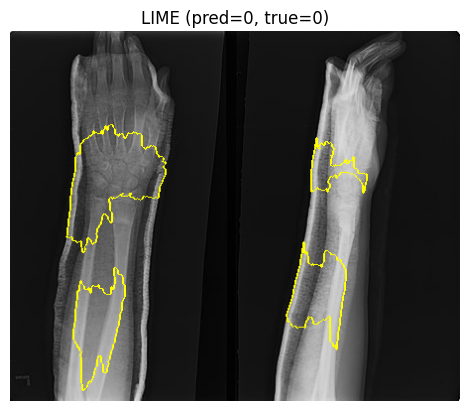

In [34]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset

SEED = 42
explainer = lime_image.LimeImageExplainer(random_state=SEED)

def pick_val_sample(val_subset: Subset, k: int = 0, want_label: int | None = None):
    base = val_subset.dataset
    samples = getattr(base, "samples", getattr(base, "imgs", None))
    targets = getattr(base, "targets", None)
    assert samples is not None, "Base dataset must be an ImageFolder with .samples/.imgs"
    if want_label is not None and targets is not None:
        idx = next(i for i in val_subset.indices if targets[i] == want_label)
    else:
        idx = val_subset.indices[k]
    return samples[idx]  # (path, label)

def explain_one(val_subset: Subset, k: int = 0, want_label: int | None = None, num_features: int = 5):
    # 1) choose a single example
    img_path, true_label = pick_val_sample(val_subset, k=k, want_label=want_label)
    raw = Image.open(img_path).convert("RGB")

    # 2) get model's predicted class for this image
    preprocess = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    ])
    x = preprocess(raw).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_label = torch.softmax(model(x), dim=1).argmax(1).item()

    # 3) run LIME for this one image and the predicted label
    def batch_predict(images):
        model.eval()
        batch = torch.stack([
            preprocess(Image.fromarray(i)).to(device) for i in images
        ], dim=0)
        with torch.no_grad():
            probs = torch.softmax(model(batch), dim=1).cpu().numpy()
        return probs

    explanation = explainer.explain_instance(
        np.array(raw),
        batch_predict,
        labels=(pred_label,),         # only explain the predicted class
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=pred_label,
        positive_only=True,
        num_features=num_features,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp/255.0, mask))
    plt.title(f"LIME (pred={pred_label}, true={true_label})")
    plt.axis("off")
    plt.show()
    return img_path, true_label, pred_label

# 👉 run on ONE example (first in val)
_ = explain_one(val_dataset, k=0)

# or explicitly pick first fracture (=1) or non-fracture (=0)
# _ = explain_one(val_dataset, want_label=1)   # fracture
# _ = explain_one(val_dataset, want_label=0)   # non-fracture


  0%|          | 0/300 [00:00<?, ?it/s]

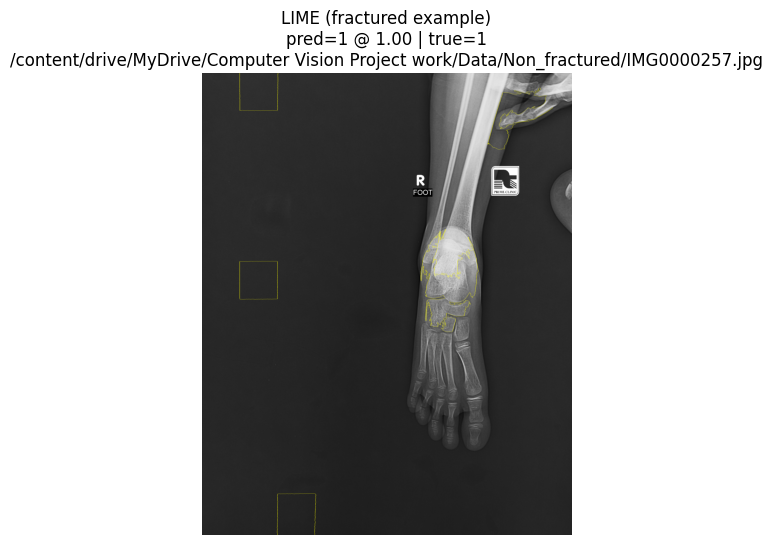

In [36]:
# ---- pick ONE fractured example from your val split ----
from torch.utils.data import Subset
from PIL import Image
import numpy as np, matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
import torch
from torchvision import transforms

# helper to pick one by class from Subset(ImageFolder)
def pick_one_by_label(val_subset: Subset, want_label: int = 1):
    base = val_subset.dataset
    samples = getattr(base, "samples", getattr(base, "imgs", None))
    targets = getattr(base, "targets", None)
    for idx in val_subset.indices:
        if targets[idx] == want_label:
            return samples[idx]  # (path, label)
    raise ValueError(f"No sample with label={want_label} in val set.")

img_path, true_label = pick_one_by_label(val_dataset, want_label=1)  # 1 = fractured
raw = Image.open(img_path).convert("RGB")

# ---- preprocess ONCE (reused) ----
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# predict class for this one image
model.eval()
with torch.inference_mode():
    preds = torch.softmax(model(preprocess(raw).unsqueeze(0).to(device)), dim=1)[0].cpu().numpy()
pred_label = int(np.argmax(preds))
pred_conf  = float(preds[pred_label])

# ---- fast LIME settings ----
explainer = lime_image.LimeImageExplainer(random_state=42)
segments_fn = lambda x: slic(x, n_segments=120, compactness=10, sigma=1, start_label=1)

def batch_predict(images):
    # vectorized, GPU batched
    batch = torch.stack([preprocess(Image.fromarray(i)) for i in images], dim=0).to(device)
    with torch.inference_mode():
        out = model(batch)
        probs = torch.softmax(out, dim=1).detach().cpu().numpy()
    return probs

explanation = explainer.explain_instance(
    np.array(raw),
    batch_predict,
    labels=(pred_label,),   # explain ONLY the predicted class
    num_samples=300,        # ↓ from 1000 -> much faster
    batch_size=64,          # let LIME batch your calls
    segmentation_fn=segments_fn,
    hide_color=0
)

temp, mask = explanation.get_image_and_mask(
    label=pred_label, positive_only=True, num_features=6, hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp/255.0, mask)); plt.axis("off")
plt.title(f"LIME (fractured example)\npred={pred_label} @ {pred_conf:.2f} | true={true_label}\n{img_path}")
plt.show()


## 6. Save Artifacts (model + history)

In [37]:

os.makedirs(EXP_DIR, exist_ok=True)
model_path = os.path.join(EXP_DIR, f"{PROJECT_NAME}_{MODEL_NAME}.pt")
torch.save(model.state_dict(), model_path)

# Save simple history CSV
import csv
hist_path = os.path.join(EXP_DIR, f"{PROJECT_NAME}_history.csv")
with open(hist_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["epoch","train_loss","train_acc","val_loss","val_acc"])
    for row in hist:
        w.writerow(row)

print("Saved:", model_path)
print("Saved:", hist_path)


Saved: /content/drive/MyDrive/fracatlas/experiments/xray-fracture-experiments_resnet50.pt
Saved: /content/drive/MyDrive/fracatlas/experiments/xray-fracture-experiments_history.csv


## 7. Next Steps

- Try **EfficientNet** or **Swin Transformer** backbones
- Handle class imbalance with **Weighted CE** or **Focal Loss**
- Add proper metrics (AUC, sensitivity, specificity)
- If you have boxes/masks, train **YOLO/Faster R-CNN** or **UNet** for localization
- Log experiments with **TensorBoard** or **Weights & Biases**